3.3:
With X-ray images.

Load the XRAY image dataset, define paths to the datasets, including the path to COVID and Non-COVID data.
Resize all images to 224x224 pixels.
Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format.
Save all file paths with their class labels to a pandas DataFrame.
Split DataFrame into train, test DataFrames using the function train_test_split(test_size=0.2) from the sklearn.model_selection library.
Add train/ test/ validation data augmentation parameters in a dictionary form or use the Keras preprocessing function.
Set training/ test/ validation parameters such as BATCH_SIZE, CLASS_MODE, COLOR_MODE, TARGET_SIZE, and EPOCHS.
Create a data generator class for reading in DICOM images or use the class provided. This custom data generator class creates a train and validation generator.
Import a pre-trained ResNet50 model from Keras for training with hyperparameters.
Train model, change hyperparameters, for example train test split proportion, batch size, vary a number of training epochs, and display variations in results.
After training finishes, plot training and validation accuracy and losses vs. epochs.
Save the model in .h5 format.
Load trained model and do predictions on 10 X-ray images.
With CT images.

Load the CT image dataset, define paths to the datasets, including the path to COVID and Non-COVID data.
Resize all images to 224x224 pixels.
Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format
Save all file paths with their class labels to a pandas DataFrame.
Split DataFrameinto train, test DataFrames using the function train_test_split(test_size=0.2) from the sklearn.model_selection library.
Add train/ test/ validation data augmentation parameters in a dictionary form or use the Keras preprocessing function.
Set training/ test/ validation parameters such as BATCH_SIZE, CLASS_MODE, COLOR_MODE, TARGET_SIZE, and EPOCHS.
Create a data generator class for reading in DICOM images or use the class provided. This custom data generator class creates a train and validation generator.
Import a pre-trained ResNet50 model from Keras for training with hyperparameters.
Train model, change hyperparameters, for example train test split proportion, batch size, vary a number of training epochs, and display variations in results.
After training finishes, plot training and validation accuracy and losses vs. epochs.
Save the model in .h5 format.
Load trained model and do predictions on 10 CT images.

(1)

In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

csv_file = '/content/drive/My Drive/Colab Notebooks/data/ct_dicom.csv'

df = pd.read_csv(csv_file, dtype=str)
df.head()

,image_path,target
0,/content/drive/My Drive/Colab Notebooks/data/D...,1
1,/content/drive/My Drive/Colab Notebooks/data/D...,1
2,/content/drive/My Drive/Colab Notebooks/data/D...,1
3,/content/drive/My Drive/Colab Notebooks/data/D...,1
4,/content/drive/My Drive/Colab Notebooks/data/D...,1


(2)

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [4]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 8.5MB/s 


In [5]:
!pip install tensorflow==1.15.5

     |████████████████████████████████| 110.5MB 52kB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 512kB 37.5MB/s 
     |████████████████████████████████| 3.8MB 35.8MB/s 
     |████████████████████████████████| 2.9MB 38.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=1fc35eddf12a22527a1eb1c6a58ef948926d6dbe0260033973f3f145b9709a7d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0

In [1]:
!pip install q keras==1.2.2

     |████████████████████████████████| 184kB 7.8MB/s 
     |████████████████████████████████| 2.8MB 13.5MB/s 
  Created wheel for keras: filename=Keras-1.2.2-cp37-none-any.whl size=209602 sha256=f11ec319e2d1d1cb03acb9dc0ab1ebe2eccaa816796371d6ed8fdb4917158c4a
  Stored in directory: /root/.cache/pip/wheels/55/07/cf/b32db0a8d243b2fd6759d5d7cb650aa20670b2b740209cbf7e
  Created wheel for theano: filename=Theano-1.0.5-cp37-none-any.whl size=2668111 sha256=32b7d3fddcf4f57c8a21d409b71437da13c412415d971f9af26742e47b4403f0
  Stored in directory: /root/.cache/pip/wheels/89/40/74/3a0b7d937890c66c4373120117ebf4ba99f4889b4a0a6a810c
Successfully built keras theano
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.__version__
import keras
keras.__version__

TensorFlow 1.x selected.
Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


'2.3.1'

(3)

In [ ]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

# tested on tf 2.1 

class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
              
        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array
    
      
# read data
# Assuming it has two cols:
# image_path: path to each image with its extension
# target: labels (here it is 0s and 1s) -> binary classification
#done!
#df = pd.read_csv("yourDfPath.csv", dtype=str)

# split for testing
# done!
#train_df, test_df = train_test_split(df, test_size=0.2)

# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 10
SEED = 1337

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


train_generator = DCMDataFrameIterator(dataframe=train,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=train_augmenter,
                             **train_consts)

valid_generator = DCMDataFrameIterator(dataframe=train,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=valid_augmenter,
                             **valid_consts)



Found 348 validated image filenames belonging to 2 classes.
Found 87 validated image filenames belonging to 2 classes.


(1)(f)

In [3]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve

In [4]:
from keras.optimizers import Adam, SGD

# Step1: load the ResNEt network, ensuring the head FC layer sets are left off
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Step 2: construct the head of the model that will be placed on top of the the base model
outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

# Step 3: place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=res.input, outputs=outputs)
opt = Adam(lr=0.00001)

# Step4: loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer= opt, 
        metrics=['accuracy']
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step


ValueError: ignored

In [ ]:
model.summary()

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#checkpoint = ModelCheckpoint("vgg16_XR_MS2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit_generator(
	generator=train_generator,
	steps_per_epoch=5,
	epochs=EPOCHS,
	validation_data=valid_generator,
	validation_steps=10
)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

Prediction: 
Normal1.0


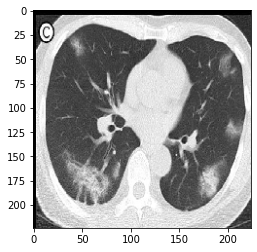

In [ ]:
x, y = test_generator.next()
run = new_model.predict(np.expand_dims(x[0], axis=0))[0]
print("Prediction: ")

if run[0] > run[1]:
    print("Covid " + str(run[0]))
else:
    print("Normal" + str(run[1]))

plot.imshow(x[0])